# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are two main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding, fetching, and storage
2. Matching

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

## Imports

In [64]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.wkt import dumps, loads
from pathlib import Path
import multiprocessing as mp
import datetime
import psycopg2
from psycopg2 import sql, extras
import random

# ensure helpers is loaded correctly
import importlib
importlib.reload(h)

<module 'helpers' from '/Users/sra/files/projects/matching_optimization/helpers.py'>

## Retrieve Generated Test Data

In [27]:
prev_month_blobs = gpd.read_parquet('data/prev_month_blobs.parquet')
curr_month_blobs = gpd.read_parquet('data/curr_month_blobs.parquet')

In [ ]:
# save to geojson to confirm in QGIS
blobs_geojson = Path('data/prev_month_blobs.geojson')
if not blobs_geojson.is_file():
    prev_month_blobs.to_file('data/prev_month_blobs.geojson')
    curr_month_blobs.to_file('data/curr_month_blobs.geojson')

In [29]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.24892 26.99815, -81.15941 26.998...",b8b6bdb0-998e-4908-abb6-009bc4a35984,dhy3b1su
1,"POLYGON ((-80.90317 27.54858, -80.88212 27.548...",8a2bad09-d800-4e21-b1c9-90bf6bd6cdfc,dhykznxy
2,"POLYGON ((-82.10523 27.80206, -82.01715 27.802...",4612d125-703e-4649-a9b6-8def8bb6cf9a,dhvwkdsz
3,"POLYGON ((-81.73651 28.74404, -81.64225 28.744...",ef540d66-6724-437e-937f-e30589b85ca0,djjgtn7s
4,"POLYGON ((-81.44636 28.78946, -81.37684 28.789...",6c9e8a2a-62d7-4c88-bcbd-b741ee3dcc63,djn5gqjg


In [30]:
prev_month_blobs = prev_month_blobs[['geometry', 'id', 'geohash']]
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.24892 26.99815, -81.15941 26.998...",b8b6bdb0-998e-4908-abb6-009bc4a35984,dhy3b1su
1,"POLYGON ((-80.90317 27.54858, -80.88212 27.548...",8a2bad09-d800-4e21-b1c9-90bf6bd6cdfc,dhykznxy
2,"POLYGON ((-82.10523 27.80206, -82.01715 27.802...",4612d125-703e-4649-a9b6-8def8bb6cf9a,dhvwkdsz
3,"POLYGON ((-81.73651 28.74404, -81.64225 28.744...",ef540d66-6724-437e-937f-e30589b85ca0,djjgtn7s
4,"POLYGON ((-81.44636 28.78946, -81.37684 28.789...",6c9e8a2a-62d7-4c88-bcbd-b741ee3dcc63,djn5gqjg


In [31]:
curr_month_blobs = curr_month_blobs[['geometry', 'id', 'geohash']]
curr_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-80.87950 26.53661, -80.79580 26.536...",dd3750ec-fdb2-412d-9b23-c68c9e7eb5d9,dhwx0qpy
1,"POLYGON ((-81.11957 27.01777, -81.07988 27.017...",9be1cf44-f76a-4ffc-a4e4-c8419a1014a5,dhy3fe2b
2,"POLYGON ((-81.67003 27.44011, -81.61018 27.440...",00342c39-8dcc-4c49-bb8b-24cbdbaca92c,dhvunjrr
3,"POLYGON ((-82.13686 28.15220, -82.10178 28.152...",e551b336-dc67-4d55-a565-c4c7b6f407d0,djj85r48
4,"POLYGON ((-81.95672 29.69183, -81.88506 29.691...",0485c6ef-8d5a-4606-939c-45f7810f1e5c,djm9pg7h


In [32]:
# make data folder
Path('data/').mkdir(exist_ok=True)

# save as geoparquet
prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

In [33]:
# range_ = 10000

# fig, ax = plt.subplots(figsize=(5, 5))
# prev_month_blobs.iloc[0:range_].plot(ax=ax)
# ax.set_title(f'Viewing the first {range_} blobs')
# plt.tight_layout()

# plt.show()

In [34]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.24892 26.99815, -81.15941 26.998...",b8b6bdb0-998e-4908-abb6-009bc4a35984,dhy3b1su
1,"POLYGON ((-80.90317 27.54858, -80.88212 27.548...",8a2bad09-d800-4e21-b1c9-90bf6bd6cdfc,dhykznxy
2,"POLYGON ((-82.10523 27.80206, -82.01715 27.802...",4612d125-703e-4649-a9b6-8def8bb6cf9a,dhvwkdsz
3,"POLYGON ((-81.73651 28.74404, -81.64225 28.744...",ef540d66-6724-437e-937f-e30589b85ca0,djjgtn7s
4,"POLYGON ((-81.44636 28.78946, -81.37684 28.789...",6c9e8a2a-62d7-4c88-bcbd-b741ee3dcc63,djn5gqjg


## 1. Non-optimized process

### 1.1. Data encoding, storage, and fetching

We will use PostgreSQL and string storage for geographic information.

#### Make copy of polygon layer and convert to non-geospatial-native string (WKT) datatype

In [35]:
# copy the gdfs
prev_month_blobs_wkt = prev_month_blobs.copy()
curr_month_blobs_wkt = curr_month_blobs.copy()

In [36]:
# Convert WKT versions to strings
dfs_to_convert = [prev_month_blobs_wkt, curr_month_blobs_wkt]
prev_month_blobs_wkt, curr_month_blobs_wkt = [h.convert_col_to_string(df) for df in dfs_to_convert]

# Check result
print(prev_month_blobs_wkt.head())

Function `convert_col_to_string` executed in 0.0097 sec, CPU: 23.70%, Memory: 0.12MB
Function `convert_col_to_string` executed in 0.0064 sec, CPU: 50.00%, Memory: 0.30MB
                                            geometry  \
0  POLYGON ((-81.24892 26.998154, -81.159413 26.9...   
1  POLYGON ((-80.903174 27.548584, -80.882124 27....   
2  POLYGON ((-82.105227 27.802065, -82.017149 27....   
3  POLYGON ((-81.736515 28.744041, -81.642248 28....   
4  POLYGON ((-81.44636 28.789463, -81.376842 28.7...   

                                     id   geohash  
0  b8b6bdb0-998e-4908-abb6-009bc4a35984  dhy3b1su  
1  8a2bad09-d800-4e21-b1c9-90bf6bd6cdfc  dhykznxy  
2  4612d125-703e-4649-a9b6-8def8bb6cf9a  dhvwkdsz  
3  ef540d66-6724-437e-937f-e30589b85ca0  djjgtn7s  
4  6c9e8a2a-62d7-4c88-bcbd-b741ee3dcc63  djn5gqjg  


/Users/sra/files/projects/matching_optimization/helpers.py:408: UserWarning: Geometry column does not contain geometry.
  df[col] = df[col].apply(lambda geom: to_wkt(geom) if isinstance(geom, BaseGeometry) else str(geom))
/Users/sra/files/projects/matching_optimization/helpers.py:408: UserWarning: Geometry column does not contain geometry.
  df[col] = df[col].apply(lambda geom: to_wkt(geom) if isinstance(geom, BaseGeometry) else str(geom))


#### Save in PostgreSQL database

This is a simple version of what a "non-geospatial-native" data ingestion pipeline may look like, with the primary example being that the polygons are stored as strings, not in a spatial-friendly datatype.

In [37]:
# Convert to tuples
prev_month_blobs_wkt = h.df_itertuple(prev_month_blobs_wkt)
curr_month_blobs_wkt = h.df_itertuple(curr_month_blobs_wkt)

Function `df_itertuple` executed in 0.0002 sec, CPU: 100.00%, Memory: 0.00MB
Function `df_itertuple` executed in 0.0003 sec, CPU: 0.00%, Memory: 0.02MB


Create PostgreSQL database if it doesn't exist already. We will be using the default settings. If they need to be adjusted, refer to [`helpers.py`](helpers.py).

In [38]:
h.create_pg_db()

Database blob_matching already exists.
Function `create_pg_db` executed in 0.0290 sec, CPU: 0.00%, Memory: 0.30MB


Create and insert into tables:

In [39]:
prev_month_blobs.head(1)

,geometry,id,geohash
0,"POLYGON ((-81.24892 26.99815, -81.15941 26.998...",b8b6bdb0-998e-4908-abb6-009bc4a35984,dhy3b1su


In [40]:
prev_month_blobs_wkt[0]

('POLYGON ((-81.24892 26.998154, -81.159413 26.998154, -81.159413 27.072767, -81.24892 27.072767, -81.24892 26.998154))',
 'b8b6bdb0-998e-4908-abb6-009bc4a35984',
 'dhy3b1su')

In [41]:
h.create_pg_table(table_name='prev_blobs_wkt', data=prev_month_blobs_wkt, truncate=True)
h.create_pg_table(table_name='curr_blobs_wkt', data=curr_month_blobs_wkt, truncate=True)

Table prev_blobs_wkt truncated.
Inserted 1000 records into prev_blobs_wkt.
Function `create_pg_table` executed in 0.0708 sec, CPU: 0.00%, Memory: 0.00MB
Table curr_blobs_wkt truncated.
Inserted 1000 records into curr_blobs_wkt.
Function `create_pg_table` executed in 0.0434 sec, CPU: 0.00%, Memory: 0.00MB


Retrieve data as GeoDataFrames to confirm that it worked:

In [42]:
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

Retrieved 1000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0111 sec, CPU: 0.00%, Memory: 0.00MB
Retrieved 1000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0074 sec, CPU: 0.00%, Memory: 0.00MB


Compare the tables before and after for a sanity check:

In [43]:
df_prev.head()

,geometry,id,geohash
0,"POLYGON ((-81.24892 26.998154, -81.159413 26.9...",b8b6bdb0-998e-4908-abb6-009bc4a35984,dhy3b1su
1,"POLYGON ((-80.903174 27.548584, -80.882124 27....",8a2bad09-d800-4e21-b1c9-90bf6bd6cdfc,dhykznxy
2,"POLYGON ((-82.105227 27.802065, -82.017149 27....",4612d125-703e-4649-a9b6-8def8bb6cf9a,dhvwkdsz
3,"POLYGON ((-81.736515 28.744041, -81.642248 28....",ef540d66-6724-437e-937f-e30589b85ca0,djjgtn7s
4,"POLYGON ((-81.44636 28.789463, -81.376842 28.7...",6c9e8a2a-62d7-4c88-bcbd-b741ee3dcc63,djn5gqjg


In [44]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.24892 26.99815, -81.15941 26.998...",b8b6bdb0-998e-4908-abb6-009bc4a35984,dhy3b1su
1,"POLYGON ((-80.90317 27.54858, -80.88212 27.548...",8a2bad09-d800-4e21-b1c9-90bf6bd6cdfc,dhykznxy
2,"POLYGON ((-82.10523 27.80206, -82.01715 27.802...",4612d125-703e-4649-a9b6-8def8bb6cf9a,dhvwkdsz
3,"POLYGON ((-81.73651 28.74404, -81.64225 28.744...",ef540d66-6724-437e-937f-e30589b85ca0,djjgtn7s
4,"POLYGON ((-81.44636 28.78946, -81.37684 28.789...",6c9e8a2a-62d7-4c88-bcbd-b741ee3dcc63,djn5gqjg


Confirm that the original blob dfs and the retrieved dfs are the same:

In [45]:
def round_geometry(geom, precision=6):
    """Round all coordinates of a geometry to a given precision."""
    return shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=precision))

# Convert both to sets of rounded WKT strings
set_prev_month_blobs = set(prev_month_blobs['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))
set_df_prev = set(df_prev['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))

# Find common, missing, and extra geometries
common_geometries = set_prev_month_blobs & set_df_prev
missing_from_retrieved = set_prev_month_blobs - set_df_prev
extra_in_retrieved = set_df_prev - set_prev_month_blobs

# Print summary
print(f"Number of matching geometries: {len(common_geometries)}")
print(f"Missing geometries in retrieved table: {len(missing_from_retrieved)}")
print(f"Extra geometries in retrieved table: {len(extra_in_retrieved)}")

# Show an example missing/extra geometry for debugging
if missing_from_retrieved:
    print("Example missing record:", next(iter(missing_from_retrieved)))

if extra_in_retrieved:
    print("Example extra record:", next(iter(extra_in_retrieved)))

Number of matching geometries: 1000
Missing geometries in retrieved table: 0
Extra geometries in retrieved table: 0


It worked! Now we can proceed to "matching" any "previous" polygons that overlap with the "current" polygons.

### 1.2. Matching

We will match the polygons using GeoPandas.

In [46]:
start = datetime.datetime.now()
print('Start time:', start)
postgresql_details = h.pg_details()
h.run_parallel_matching(table_prev='prev_blobs_wkt', 
                        table_curr='curr_blobs_wkt', 
                        output_table='matched_results', 
                        postgresql_details=postgresql_details, 
                        db_name='blob_matching', 
                        num_workers=5,
                        verbose=2)
end = datetime.datetime.now()
print('End time:', end)
print('Total time:', end - start)

Start time: 2025-03-02 15:29:07.592578
Table matched_results created successfully.
Total batches to process: 1
Dispatched batch 1/1 (100.0% complete)
Waiting for process 10648 to finish.
match_geometries: 10% of rows processed, 0 matches found
match_geometries: 20% of rows processed, 2 matches found
match_geometries: 30% of rows processed, 3 matches found
match_geometries: 40% of rows processed, 5 matches found
match_geometries: 50% of rows processed, 6 matches found
match_geometries: 60% of rows processed, 9 matches found
match_geometries: 70% of rows processed, 10 matches found
match_geometries: 80% of rows processed, 10 matches found
match_geometries: 90% of rows processed, 11 matches found
match_geometries: 100% of rows processed, 12 matches found
Logging listener has shut down.
Function `run_parallel_matching` executed in 21.5779 sec, CPU: 36.50%, Memory: 191.14MB
End time: 2025-03-02 15:29:29.171485
Total time: 0:00:21.578907


In [47]:
# # testing logging for matching_geometries
# df_prev = h._retrieve_pg_table(postgresql_details, 'blob_matching', "prev_blobs_wkt")#, log_enabled=True)
# df_curr = h._retrieve_pg_table(postgresql_details, 'blob_matching', "curr_blobs_wkt")#, log_enabled=True)

# # Use a small subset for testing
# # df_prev_sample = df_prev.sample(10, random_state=42)
# # df_curr_sample = df_curr.sample(10, random_state=42)

# # h.match_geometries(df_prev_sample, df_curr_sample)  # Check if this logs matches
# h.match_geometries(df_prev, df_curr)  # Check if this logs matches

Confirm that the postgres matching table has the same number of matches:

In [48]:
count = h.retrieve_pg_table(table_name='matched_results', count=True)

Total matches in matched_results: 12
Function `retrieve_pg_table` executed in 0.0051 sec, CPU: 28.60%, Memory: 0.00MB


In [49]:
# save log files as .parquet
h.convert_logs_to_parquet(csv_path=Path('logs/timing_results.csv'),
                          log_path=Path('logs/timing.log'))
print('Done.')

Converted logs/timing_results.csv to logs/timing_results.parquet
Converted logs/timing.log to logs/timing_log.parquet
Done.


View the overall polygon layers and then some subplots with locations of the matched polygons:

Retrieved 1000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0344 sec, CPU: 44.00%, Memory: 58.86MB
Retrieved 1000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0143 sec, CPU: 0.00%, Memory: 17.41MB
Retrieved 12 records from matched_results.


/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_8427/3701104119.py:47: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax_main.legend()
/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_8427/3701104119.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_main.legend()


IndexError: index 4 is out of bounds for axis 1 with size 4

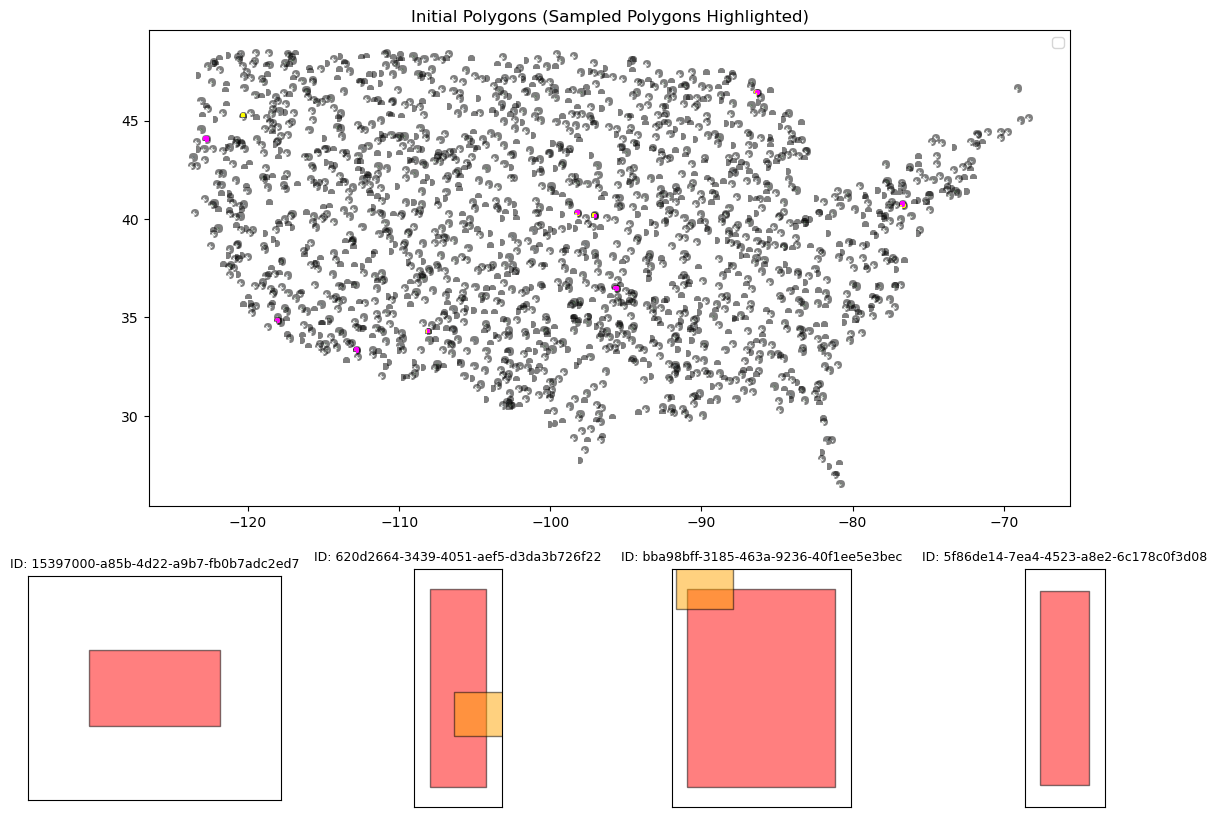

In [ ]:
# Retrieve tables from PostgreSQL
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# Sample 10 overlapping polygons
sample_size = min(10, len(overlapping_a))  # Ensure we don't sample more than available
sample_indices = random.sample(range(len(overlapping_a)), sample_size)
sample_a = overlapping_a.iloc[sample_indices]
sample_b = overlapping_b.iloc[sample_indices]

# Define figure layout with GridSpec
fig = plt.figure(figsize=(15, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[2, 1, 1], width_ratios=[1, 1, 1, 1])  

# --- Main Plot: Initial Polygons ---
ax_main = plt.subplot(gs[0, :])  # Top row spans all columns
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)#, linewidth=5)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)#, linewidth=5)

# Overlay highlighted sampled polygons with a thick outline
sample_a.plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=3, linestyle='dashed', label="Sampled Prev", zorder=3)
sample_b.plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=3, linestyle='dashed', label="Sampled Curr", zorder=3)

ax_main.set_title("Initial Polygons (Sampled Polygons Highlighted)")
ax_main.legend()

# --- Zoomed-in Subplots (2nd and 3rd row) ---
for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = plt.subplot(gs[(i // 5) + 1, i % 5])  # Distribute across rows 2 and 3
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Plot zoomed-in view
    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Get bounding box
    buffer = 0.01  # Add a small margin for better visualization
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Add ID as a title
    ax.set_title(f"ID: {row['id']}", fontsize=9)
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

Retrieved 1000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0363 sec, CPU: 32.10%, Memory: 35.23MB
Retrieved 1000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0091 sec, CPU: 33.40%, Memory: 0.20MB
Retrieved 15 records from matched_results.
Retrieved 1000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0082 sec, CPU: 0.00%, Memory: 2.34MB
Retrieved 1000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0080 sec, CPU: 0.00%, Memory: 0.00MB
Retrieved 12 records from matched_results.


IndexError: index 4 is out of bounds for axis 1 with size 4

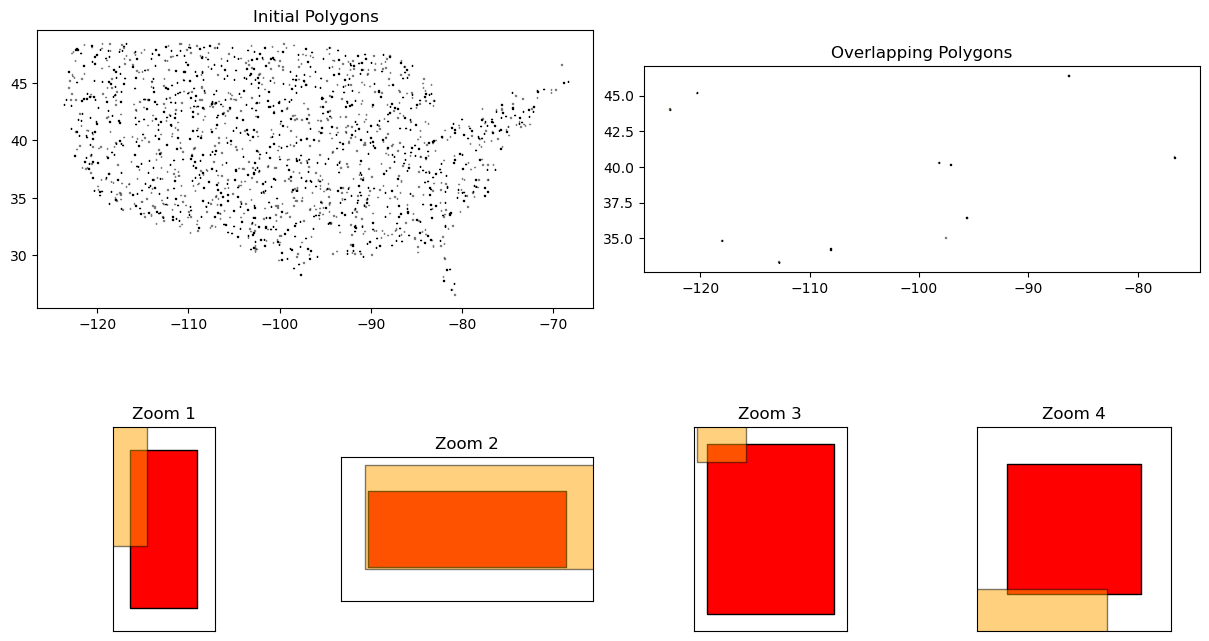

In [65]:
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# ensure they are geodataframes
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
# retrieve data
cur.execute(sql.SQL(f"SELECT prev_id, curr_id FROM {table_name};"))
rows = cur.fetchall()
cur.close()
conn.close()
# Convert to DataFrame & reapply geometry
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
# df["geometry"] = df["geometry"].apply(loads)  # Convert WKT to Shapely geometry
print(f"Retrieved {len(table_name)} records from {table_name}.")

# Retrieve tables from PostgreSQL
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# Sample 10 overlapping polygons
sample_size = min(10, len(overlapping_a))  # Ensure we don't sample more than available
sample_indices = random.sample(range(len(overlapping_a)), sample_size)
sample_a = overlapping_a.iloc[sample_indices]
sample_b = overlapping_b.iloc[sample_indices]

# Define the figure with GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(3, 4, height_ratios=[2, 1, 1], width_ratios=[1, 1, 1, 1])  # Bigger main plots, smaller zoomed plots

# --- Main Plot: All polygons (occupies top left) ---
ax_main1 = plt.subplot(gs[0, 0:2])  # Spans first two columns
df_prev.plot(ax=ax_main1, color='lightblue', edgecolor='black')
df_curr.plot(ax=ax_main1, color='lightgreen', edgecolor='black', alpha=0.5)
ax_main1.set_title("Initial Polygons")

# --- Main Plot: Overlapping polygons (occupies top right) ---
ax_main2 = plt.subplot(gs[0, 2:4])  # Spans last two columns
overlapping_a.plot(ax=ax_main2, color='red', edgecolor='black')
overlapping_b.plot(ax=ax_main2, color='orange', edgecolor='black', alpha=0.5)
ax_main2.set_title("Overlapping Polygons")

# --- Zoomed-in Subplots (Grid of 2 rows x 5 columns) ---
for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = plt.subplot(gs[(i // 5) + 1, i % 5])  # Distribute across rows 2 and 3
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Plot zoomed-in view
    subset_a.plot(ax=ax, color="red", edgecolor="black")
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)
    
    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Get bounding box
    buffer = 0.01  # Add a small margin for better visualization
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    ax.set_title(f"Zoom {i+1}")
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

## 2. Optimized Approach

Having demonstrated a reasonable if not optimized way of matching polygons, we will now make use of geospatial-native tools to hopefully match polygons much more quickly.

My proposed workflow centers around `DuckDB` and `H3` along with the `.parquet` format to efficiently store, retrieve, and process geospatial data. We will use `Apache Iceberg` as a layer over the parquet file as it allows for more robust table handling.

1. Prepare GeodataFrames with H3 Polyfill and parent hexagons at lower resolution.
   * Save as an Iceberg table.

2. Use DuckDB and the H3 extension to execute spatial SQL queries to find overlapping polygons with H3-based joins.

3. Save matching polygon IDs to a new Iceberg table.

4. Visualize the results.

### 2.1. Add H3 data to the blobs

H3 is a modern and efficient geospatial index paradigm that divides the world into nested hexagons.

In [902]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.10504 26.01885, -81.04984 26.018...",6cc95c8a-cbaf-4993-a9ff-4e890c7e45f0,dhwk5h
1,"POLYGON ((-80.91675 26.04190, -80.86358 26.041...",a0fbead2-d8dc-4e05-b364-ab89d020fbfb,dhwkpq
2,"POLYGON ((-80.73525 26.20304, -80.71903 26.203...",b4c64915-35eb-4d74-a211-ce41ad8f21f8,dhwt55
3,"POLYGON ((-80.86288 26.17613, -80.79088 26.176...",d03d2784-ff88-4ed6-b93c-2b52a8a7ecc3,dhwt0s
4,"POLYGON ((-81.28584 26.19397, -81.21442 26.193...",0ce2ca44-0727-4364-978b-da23cd9cd784,dhwjpj


In [903]:
def compute_h3_indices(geometry, centroid_res=6, polyfill_res=9):
    """
    Compute H3 indices for a polygon:
    - Single H3 index based on centroid
    - Full polygon coverage with H3 polyfill at high resolution
    """
    centroid = geometry.centroid
    h3_centroid = h3.geo_to_h3(centroid.y, centroid.x, centroid_res)

    # Full coverage using polyfill
    h3_polyfill = list(h3.polyfill(geometry.__geo_interface__, polyfill_res))

    return h3_centroid, h3_polyfill

In [ ]:
test_prev = prev_month_blobs.copy()
test_curr = curr_month_blobs.copy()

for gdf in [test_prev, test_curr]:
    gdf['h3_centroid'] = gdf['geometry'].apply(lambda geom: compute_h3_indices(geom, 6, 9))

In [899]:
print(type(prev_month_blobs))
prev_month_blobs.head(3)
# prev_month_blobs = gpd.read_parquet('data/prev_month_blobs.parquet')
# curr_month_blobs = gpd.read_parquet('data/curr_month_blobs.parquet')

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,id,geohash
0,"POLYGON ((-81.10504 26.01885, -81.04984 26.018...",6cc95c8a-cbaf-4993-a9ff-4e890c7e45f0,dhwk5h
1,"POLYGON ((-80.91675 26.04190, -80.86358 26.041...",a0fbead2-d8dc-4e05-b364-ab89d020fbfb,dhwkpq
2,"POLYGON ((-80.73525 26.20304, -80.71903 26.203...",b4c64915-35eb-4d74-a211-ce41ad8f21f8,dhwt55


# Notes on original process

geohash polygon into a larger region
match blobs using multiprocessing (mp.Process) and geopandas
find blobs from previous month that do not have a match

# 1 imports and setup

```python
import os, sys, traceback
import argparse
import cv2
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io, color, measure
from tqdm import tqdm
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import PIL
from PIL import Image, ImageDraw, ImageEnhance
import uuid
import multiprocessing as mp
from datetime import datetime
from sqlalchemy import or_
from sqlmodel import SQLModel, Session, create_engine, select
from pathlib import Path
```

## Key takeaways
- Uses Pandas and GeoPandas for data processing.
- Uses Shapely for geospatial geometry operations.
- Uses multiprocessing (mp) to parallelize the blob-matching process.
- Uses SQLAlchemy and SQLModel for database operations.

# 2 High-level script overview
The script is designed to match blobs (spatial objects) between two months and classify them into different business categories.

General Workflow
1. Fetch blobs from the previous and current months.
1. Convert the region of interest (state, city, county, or geohash) into a list of geohashes.
1. Parallelized Matching Process:
1. Process multiple geohashes at once using multiprocessing.
1. Find corresponding blobs from previous months for each geohash.
1. Classify blobs based on construction stage progression.
1. Identify blobs that are missing in the current month and "impute" them.
1. Save results into the database.

# 3 Blob classification logic

# 4 Blob matching

- Matches blobs between months using polygon intersections.
- Uses Shapely to validate geometries and check for overlaps.
- Returns matched blob IDs.

## Multiprocessing Optimization
The script parallelizes blob matching by:
- Uses multiprocessing (mp.Process) to divide the dataset into smaller batches.
- Each batch of blobs is processed in parallel.
- Reduces runtime compared to a single-threaded approach.

# 5 Handling unmatched blobs
- Finds blobs from the previous month that do not have a match in the current month.
- These blobs are "imputed", meaning they are carried over into the new month.

# 6 Main class to orchestrate process
- Loads previous and current month blobs.
- Converts input regions (state, city, county) into geohashes.

# Summary
- Parallel processing is used to match blobs.
- Blobs are classified based on construction stages.
- Unmatched blobs are imputed for continuity.
- The script writes results to a database.